# Iterative method of matrix factorzation
## 1. Set up data

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

In [2]:
SAVE_FIG = True
PLOT_PATH = "plots/"

In [3]:
# Reading ratings file
ratings = pd.read_csv('ml-1m/ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'rating', 'timestamp'])
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

# Calculate the sparsity
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print ('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

# Fill NaN witn 0
ratings_matrix_df = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
ratings_matrix_df.head()

Number of users = 6040 | Number of movies = 3706
The sparsity level of MovieLens1M dataset is 95.5%


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ratings_matrix = ratings_matrix_df.values
print("Shape of the rating matrix:", ratings_matrix.shape)
user_ratings_mean = np.mean(ratings_matrix, axis = 1)
ratings_demeaned = ratings_matrix - user_ratings_mean.reshape(-1, 1)

Shape of the rating matrix: (6040, 3706)


## 2. Matrix factorization

In [5]:
# Helper functions
def index_of_nonzero(matrix):
    return np.argwhere(matrix != 0)

In [6]:
class Matrix_Factorization():
    def __init__(self, data, features):
        # Set up data
        self._data = data
        self._features = features
        self._user_count, self._item_count = data.shape
        self._mean = data.mean()
        self._nonzero_indices = index_of_nonzero(data)
        self._nonzero_indices_array = np.nonzero(data)

        # Training parameters
        self._user_bias = np.random.uniform(low=-1, high=1, size=self._user_count)
        self._item_bias = np.random.uniform(low=-1, high=1, size=self._item_count)
        self._user_features = np.random.uniform(low=0.1, 
                                                high=0.5, 
                                                size=(self._user_count, self._features))
        self._item_features = np.random.uniform(low=0.1, 
                                                high=0.5, 
                                                size=(self._features, self._item_count))
    def predict(self, idx_u, idx_i):
        """ Make a prediction of user u to item i """
        mean, user_bias, item_bias = self._mean, self._user_bias, self._item_bias
        u_row = self._user_features[idx_u, :]
        i_col = self._item_features[:, idx_i]
        pred_ui = mean + user_bias[idx_u] + item_bias[idx_i] + float(np.dot(u_row, i_col))
        return pred_ui

    def evaluate(self):
        data = self._data
        nonzero_rows, nonzero_cols = self._nonzero_indices_array
        mean, user_bias, item_bias = self._mean, self._user_bias, self._item_bias
        user_features, item_features = self._user_features, self._item_features
        
        # get the predicted matrix
        len_user_bias = len(user_bias)
        pred_matrix = mean + np.matmul(user_features, item_features) + user_bias.reshape([len_user_bias, 1]) + item_bias
        
        past_ratings = data[nonzero_rows, nonzero_cols]
        predicted_ratings = pred_matrix[nonzero_rows, nonzero_cols]
        # calculate the RMSE training loss
        train_loss = (np.sum((past_ratings - predicted_ratings) ** 2) / len(past_ratings)) ** (1 / 2)
        return pred_matrix, train_loss

    def get_grad(self, idx_u, idx_i, l2_reg=0.001):
        """ Calculate negative of gradients wrt. training parameters """
        data = self._data
        user_bias, item_bias = self._user_bias, self._item_bias
        user_features, item_features = self._user_features, self._item_features
        
        # make prediction and calculate error
        pred_ui = self.predict(idx_u, idx_i)        
        err_ui = data[idx_u, idx_i] - pred_ui

        # calculate negative gradients
        user_bias_grad_u = err_ui - l2_reg * user_bias[idx_u]
        item_bias_grad_i = err_ui - l2_reg * item_bias[idx_i]
        user_features_grad_u = err_ui * item_features[:, idx_i] - l2_reg * user_features[idx_u, :]
        item_features_grad_i = err_ui * user_features[idx_u, :] - l2_reg * item_features[:, idx_i]

        return user_bias_grad_u, item_bias_grad_i, user_features_grad_u, item_features_grad_i


    def train(self, learning_rate=0.02, epochs=100, l2_reg=0.001, nodes=10):    
        nonzero_indices, len_indices = self._nonzero_indices, len(self._nonzero_indices)
        data = self._data
        loss_history = []
        for epoch in range(epochs):
            # federated nodes
            indices_arr = np.arange(len_indices)
            idx_array_list = np.array_split(indices_arr, nodes)
            total_iters = len(idx_array_list[-1])
            
            # randomly shuffle
            for idx_node in range(nodes):
                np.random.shuffle(idx_array_list[idx_node])

            for num_iter in range(total_iters):
                for idx_node in range(nodes):
                    idx_u, idx_i = nonzero_indices[idx_array_list[idx_node][num_iter]]

                    # calculate negative gradients
                    (user_bias_grad_u, 
                     item_bias_grad_i, 
                     user_features_grad_u, 
                     item_features_grad_i) = self.get_grad(idx_u, idx_i, l2_reg)

                    # update parameters
                    self._user_bias[idx_u] = self._user_bias[idx_u] + learning_rate * user_bias_grad_u
                    self._item_bias[idx_i] = self._item_bias[idx_i] + learning_rate * item_bias_grad_i
                    self._user_features[idx_u, :] = self._user_features[idx_u, :] + learning_rate * user_features_grad_u
                    self._item_features[:, idx_i] = self._item_features[:, idx_i] + learning_rate * item_features_grad_i
            
            dummy, current_loss = self.evaluate()
            loss_history.append(current_loss)
            if epoch % 10 == 0:
                print("Epoch:", epoch, "|", "Loss:", current_loss)
        return loss_history

In [7]:
# 10 nodes
rating_instance = Matrix_Factorization(ratings_matrix, 50)
loss_history = rating_instance.train()
pred_matrix, loss = rating_instance.evaluate()

Epoch: 0 | Loss: 0.9216999947736771
Epoch: 10 | Loss: 0.6315086067561131
Epoch: 20 | Loss: 0.5881771973316068
Epoch: 30 | Loss: 0.5711037055501683
Epoch: 40 | Loss: 0.5609190226866958
Epoch: 50 | Loss: 0.5547850281553615
Epoch: 60 | Loss: 0.5500712270088788
Epoch: 70 | Loss: 0.5453173251328286
Epoch: 80 | Loss: 0.543300143148335
Epoch: 90 | Loss: 0.5408018334122267


Best loss is: 0.53949271339566


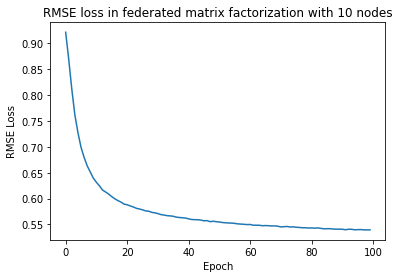

In [13]:
LOG_PATH = "log/"

def plot_convergence(loss_history_list, title):
    """ Convergence plot """
    fig, axs = plt.subplots()
    axs.plot(loss_history_list)
    axs.set_title(title)
    axs.set_xlabel('Epoch')
    axs.set_ylabel('RMSE Loss')
    print("Best loss is:", min(loss_history_list))

    with open(LOG_PATH + title + ".txt", 'w') as file:
        for item in loss_history_list:
            file.write("%s\n" % item)
    
    if SAVE_FIG:
        fig.savefig(PLOT_PATH + title + ".pdf")
    return fig

fig_loss = plot_convergence(loss_history, title="RMSE loss in federated matrix factorization with 10 nodes")

<Figure size 432x288 with 0 Axes>

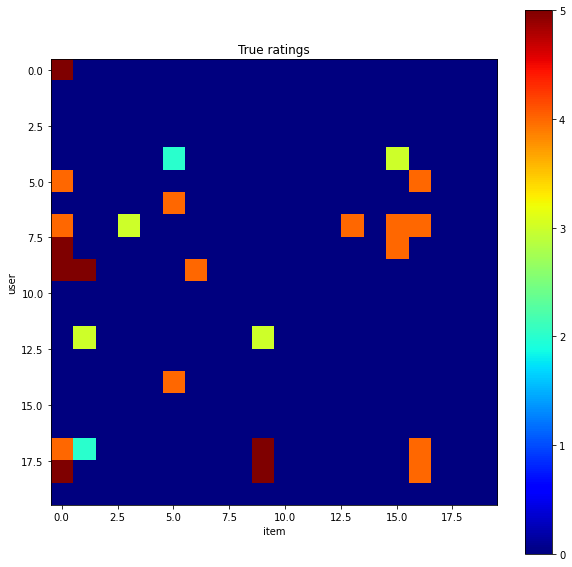

<Figure size 432x288 with 0 Axes>

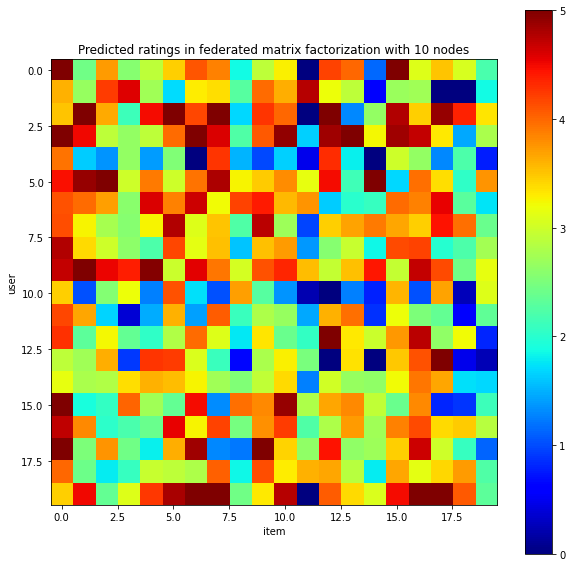

In [19]:
Rpred = pred_matrix
Rpred[Rpred < 0] = 0
Rpred[Rpred > 5] = 5

# plots of rating data and predicted matrix
nusers = 20
nitems = 20

fig = plt.figure()
title = 'True ratings'
plt.figure(figsize=(10, 10))
plt.imshow(ratings_matrix[:nusers, :nitems], cmap='jet', vmin=0, vmax=5)
plt.xlabel('item')
plt.ylabel('user')
plt.title(title)
plt.colorbar()
if SAVE_FIG:
    plt.savefig(PLOT_PATH + title + ".pdf")


fig = plt.figure()
title = 'Predicted ratings in federated matrix factorization with 10 nodes'
plt.figure(figsize=(10, 10))
plt.imshow(Rpred[:nusers, :nitems], cmap='jet', vmin=0, vmax=5)
plt.xlabel('item')
plt.ylabel('user')
plt.title(title)
plt.colorbar()
if SAVE_FIG:
    plt.savefig(PLOT_PATH + title + ".pdf")

## 3. Recommendations

In [15]:
def recommend_movies(preds_df, user_id, movies_df, original_ratings_df, num_recommendations=5):
    """Get the past ratings of a user and predicted ratings"""
    
    # Get and sort the user's predictions
    user_row_number = user_id - 1 # user_id starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # user_id starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (user_id)]
    user_full = (user_data.merge(movies_df, how='left', left_on='movie_id', right_on='movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(user_id, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movie_id'].isin(user_full['movie_id'])].
                       merge(pd.DataFrame(sorted_user_predictions).reset_index(), 
                             how='left', 
                             left_on='movie_id',
                             right_on='movie_id').
                       rename(columns = {user_row_number: 'Predictions'}).
                       sort_values('Predictions', ascending=False).iloc[:num_recommendations]
                      )

    return user_full, recommendations

In [16]:
# Reading movies file
movies = pd.read_csv('ml-1m/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# past ratings and predicted ratings
preds = pd.DataFrame(pred_matrix, columns=ratings_matrix_df.columns)
already_rated, predictions = recommend_movies(preds, 837, movies, ratings, 10)
already_rated.head(10)

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,user_id,movie_id,rating,timestamp,title,genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


In [17]:
predictions

,movie_id,title,genres,Predictions
2400,2511,"Long Goodbye, The (1973)",Crime,5.0
1642,1726,"Postman, The (1997)",Drama,5.0
1605,1686,Red Corner (1997),Crime|Thriller,5.0
3722,3861,"Replacements, The (2000)",Comedy,5.0
1573,1654,FairyTale: A True Story (1997),Children's|Drama|Fantasy,5.0
1532,1606,Kull the Conqueror (1997),Action|Adventure,5.0
1475,1547,Shiloh (1997),Children's|Drama,5.0
3006,3132,Daddy Long Legs (1919),Comedy,5.0
1421,1484,"Daytrippers, The (1996)",Mystery,5.0
1412,1473,Best Men (1997),Action|Comedy|Crime|Drama,5.0
